<a id='3.1'></a>
# <font size=5 face='Roboto' color='white'> Neural Networks with PyTrees</font>

In [27]:
foo = [1, (2, 3), {'a': 4, 'b': 5, 'c': [3.14, (2.17, 6.28), [70, 80, 90]]}, [10, 20, 30, {'bar': 23}]]; foo

[1,
 (2, 3),
 {'a': 4, 'b': 5, 'c': [3.14, (2.17, 6.28), [70, 80, 90]]},
 [10, 20, 30, {'bar': 23}]]

In [28]:
import jax

jax.tree_leaves(foo)

<ipython-input-28-aa28110aa39a>:3: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  jax.tree_leaves(foo)


[1, 2, 3, 4, 5, 3.14, 2.17, 6.28, 70, 80, 90, 10, 20, 30, 23]

In [29]:
jax.tree_map(lambda x: x ** 4, foo)

<ipython-input-29-8fa439763006>:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: x ** 4, foo)


[1,
 (16, 81),
 {'a': 256,
  'b': 625,
  'c': [97.21171216000002,
   (22.173739209999997, 1555.3873945600003),
   [24010000, 40960000, 65610000]]},
 [10000, 160000, 810000, {'bar': 279841}]]

In [30]:
import numpy as np
import jax.numpy as jnp
from typing import List, Dict

# code from the docs here- https://jax.readthedocs.io/en/latest/jax-101/05.1-pytrees.html#example-ml-model-parameters

def init_mlp_params(layer_widths: List) -> List[Dict]:
    params = []
    for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
        params.append(
            dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                 biases=np.ones(shape=(n_out,))
                )
        )
    return params

In [31]:
params = init_mlp_params([1, 128, 128, 64, 64, 1])

In [32]:
jax.tree_map(lambda x: x.shape, params)

<ipython-input-32-8ef643eb55c2>:1: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  jax.tree_map(lambda x: x.shape, params)


[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (64,), 'weights': (128, 64)},
 {'biases': (64,), 'weights': (64, 64)},
 {'biases': (1,), 'weights': (64, 1)}]

In [33]:
@jax.jit
def forward(params: list,
            x: jnp.ndarray):
    *hidden, last = params
    for layer in hidden:
        x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
    return x @ last['weights'] + last['biases']

@jax.jit
def loss_fn(params: list,
            x: jnp.ndarray,
            y: jnp.ndarray):
    return jnp.mean((forward(params, x) - y) ** 2)

LEARNING_RATE = 0.0001

@jax.jit
def update(params: list,
           x: jnp.ndarray,
           y: jnp.ndarray) -> list:
    grads = jax.grad(loss_fn)(params, x, y)
    return jax.tree_util.tree_map(
        lambda p, g: p - LEARNING_RATE * g, params, grads
    )

Training...:   0%|          | 0/1000 [00:00<?, ?it/s]

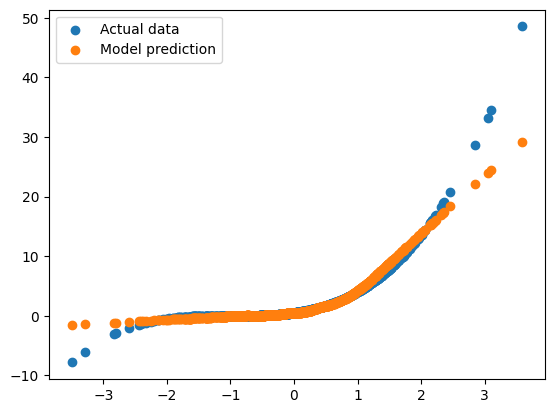

In [34]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

xs = np.random.normal(size=(1000, 1))
ys = 0.5 * (xs + 1) ** 3

for _ in tqdm(range(1000), desc='Training...'):
    params = update(params, xs, ys)

plt.scatter(xs, ys, label='Actual data')
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();